In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
import matplotlib as plt
from scipy import stats
from tqdm import tqdm

In [2]:
# Подключимся к ClickHouse
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221220',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
# Выгрузим необходимые данные за период проведения тестирования
q = """
select 
    exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes / views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-12-02' and toDate(time) <= '2022-12-08' 
    and exp_group in (1,2)
group by exp_group, user_id    
"""
df = ph.read_clickhouse(q, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [4]:
# Можно проверить себя, есть ли в наших данных дубликаты пользователей
df.user_id.duplicated().sum()

0

<AxesSubplot:xlabel='ctr', ylabel='Count'>

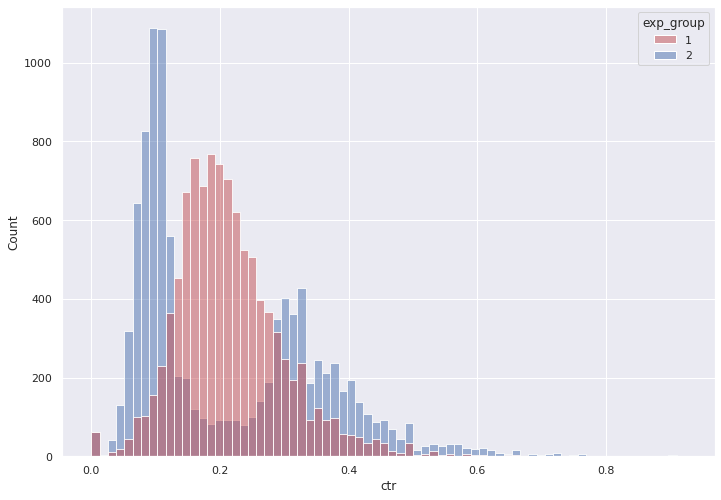

In [5]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

#### Из гистораммы можно заметить, что распределение CTR в группе 2 имеет бимодальный характер, есть подозрение, в данных присутствуют выбросы.
#### В группе 1 распределение больше похоже на нормальное (имеет 1 "горб")
_____________

## t-тест Стьюдента
Нулевая гипотеза Hо:μ1 = μ2

Альтернативная гипотеза H1:μ1 != μ2

In [6]:
stats.ttest_ind(
    df[df['exp_group']==1].ctr, 
    df[df['exp_group']==2].ctr,
    equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

#### Значение p-value 0.47 говорит, что мы не можем отклонить гипотезу о равенстве значений 2-х групп
#### Сразу появляется интерес, как себя будет вести значение p-value для сглаженного CTR?
_________________

 ## t-тест на сглаженном CTR

In [7]:
 #### формула CTR (likes + global_Ctr * alpha)/(views + alpha)
alpha = 5

In [8]:
# Посчитаем global_ctr для каждой группы
global_ctr_1 = df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum() 
global_ctr_2 = df[df.exp_group == 2].likes.sum() / df[df.exp_group == 2].views.sum()
global_ctr_1, global_ctr_2

(0.20802680490126244, 0.1980601844115994)

In [9]:
# Напишем функцию для рассчета сглаженного CTR
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [10]:
# Выделим отедльно группы 1 и 2
group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

In [11]:
# Добавим значения сглаженного CTR
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

In [12]:
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)
group2

,exp_group,user_id,likes,views,ctr,smothed_ctr
5,2,131473,14,134,0.104478,0.107844
6,2,23985,7,87,0.080460,0.086851
7,2,24523,11,101,0.108911,0.113116
8,2,32420,26,128,0.203125,0.202935
9,2,24239,40,90,0.444444,0.431477
...,...,...,...,...,...,...
20023,2,16512,1,15,0.066667,0.099515
20025,2,17146,0,10,0.000000,0.066020
20028,2,25383,42,127,0.330709,0.325684
20029,2,139020,24,114,0.210526,0.210003


<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

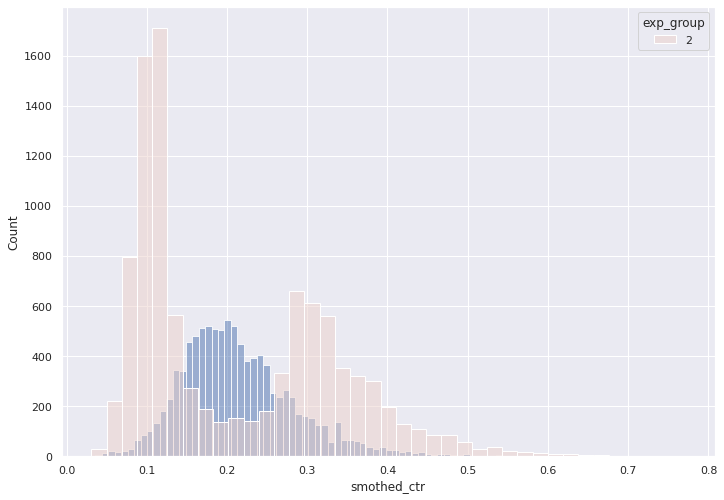

In [13]:
# Посмотрим, изменились ли графики
sns.histplot(data = group1,
             x='smothed_ctr',
             kde = False,
             hue='exp_group')
sns.histplot(data = group2,
             x='smothed_ctr',
             kde = False,
             hue='exp_group')

# Графики немного сгладились

In [14]:
stats.ttest_ind(group1.smothed_ctr,group2.smothed_ctr,equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

#### А вот и интересный результат! При проведении теста со сглаженным p-value мы вполне могли бы позволить себе отклонить нулевую гипотезу!
_________________

## Тест Манна-Уитни

In [15]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

### Тест Манна-Уитни позволяет нам отклонить нулевую гипотезу
____________

## Пуассоновский бутстреп

In [16]:
# Напишем функцию для рассчета бутстрэпа
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


In [17]:
# Посчитаем лайки и просмотры
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [18]:
# Запустим функцию
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

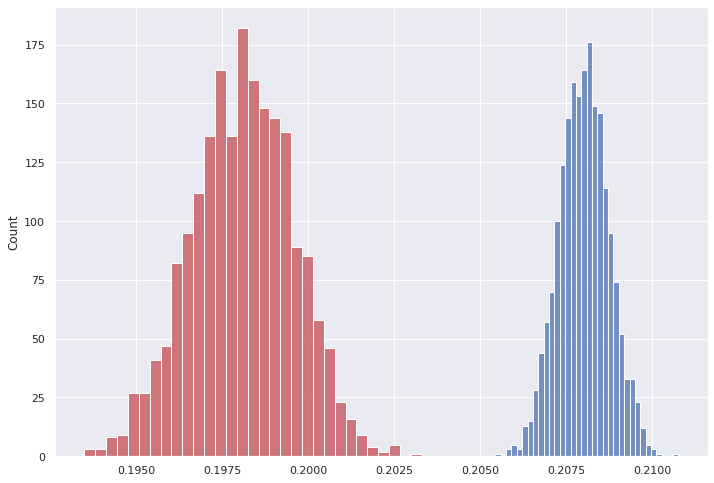

In [19]:
# Визуализируем результат
sns.histplot(ctr1, color='b')
sns.histplot(ctr2,color='r')

#### Так как распределения глобальных CTR не пересекаются, то есть p-value равно 0, что говорит нам о возможности отклонгить нулевую гипотезу об их равенстве. Также глобальный CTR контрольной группы выше, нежели тестовой.
#### Необходимо проверить себя. Посчитаем разницу глобальных STR.

<AxesSubplot:ylabel='Count'>

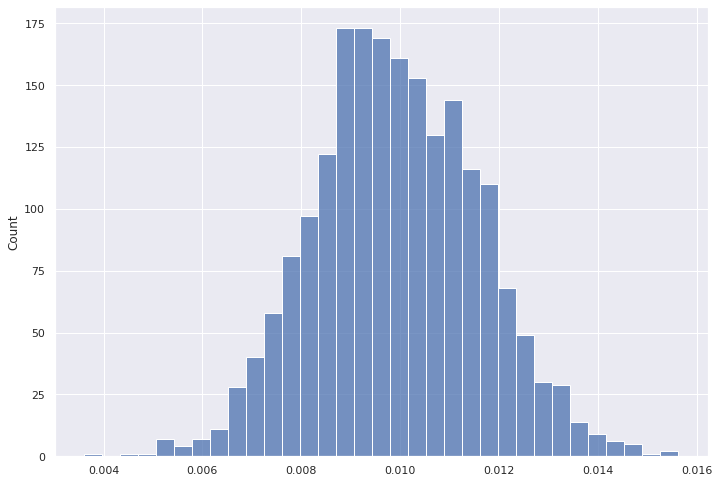

In [20]:
sns.histplot(ctr1 - ctr2)

#### Наш график показал, что глобальный CTR первой группы строго больше 0 и точно не пересекается с тестовой группой. Следовательно, можно сделать вывод, что тестовая группа показала худший результат по сравнению с контрольной. 
______________________

## Бакетное преобразование

In [21]:
# Сделаем запрос в ClickHouse для баскетного преобразования

q = """

SELECT exp_group,bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-12-02' and '2022-12-08'
        and exp_group in (1,2)
    GROUP BY exp_group,bucket, user_id)
GROUP BY exp_group, bucket
"""

bucket_df = ph.read_clickhouse(q, connection=connection)
bucket_df.head()

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262
2,1,1,0.211887
3,2,1,0.215328
4,1,2,0.206271


/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bucket_ctr', ylabel='Density'>

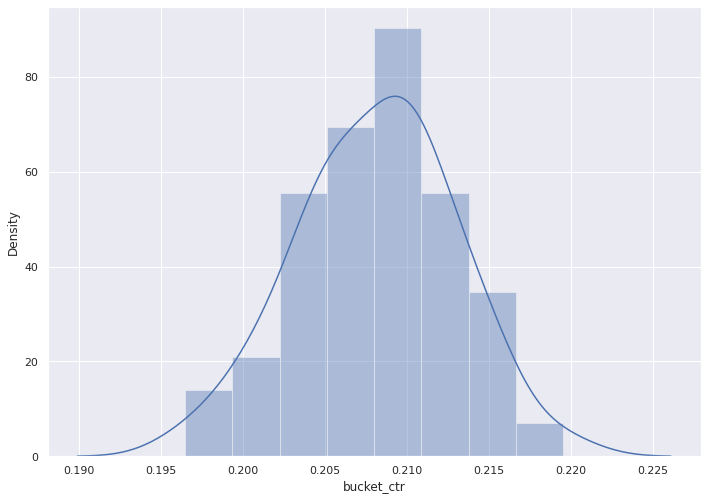

In [22]:
sns.distplot(bucket_df[bucket_df.exp_group == 1].bucket_ctr)

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bucket_ctr', ylabel='Density'>

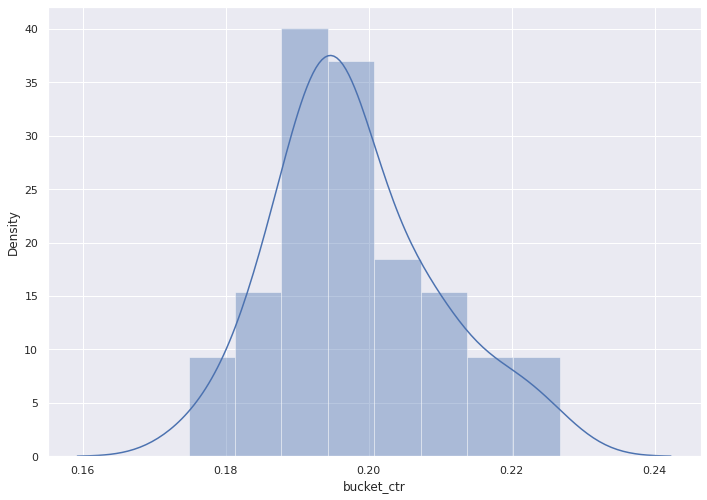

In [23]:
sns.distplot(bucket_df[bucket_df.exp_group == 2].bucket_ctr)

#### В целом, распределения близки к нормальным. Проведем t-test и тест Манна-Уитни.

In [24]:
stats.ttest_ind(bucket_df[bucket_df.exp_group == 1].bucket_ctr, 
                   bucket_df[bucket_df.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

In [25]:
stats.mannwhitneyu(bucket_df[bucket_df.exp_group == 1].bucket_ctr, 
                   bucket_df[bucket_df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

#### p-value в обоих случаях сильно меньше 0.05, что позволяет нам отклонить нулевую гипотезу
_______________

### Исходя из проведенных А/В тестов можно сделать следующие выводы:
#### При проведении t-тестов Стьюдента как с обычным CTR, так и со сглаженным данные контрольной группы оказались бимодальными и не похожими на нормальное распределение. 
#### В остальных тестах p-value оказалось меньше значения 0.05, что позволило нам отменить нулевую гипотезу.
#### Я бы остановился на наметоде Пуассоновского бутстрепа, т.к. он менее чувствителен к выбросам данных. 
#### Также можно посмотреть, какие могут быть различия лайков и просмотров в наших группах.

In [29]:
views_diff = df[df['exp_group']==1].views.sum() - df[df['exp_group']==2].views.sum()
print ('Количество просмотров контрольной группы выше, чем у тестовой на', views_diff)

Количество просмотров контрольной группы выше, чем у тестовой на 9926


<AxesSubplot:xlabel='views', ylabel='Count'>

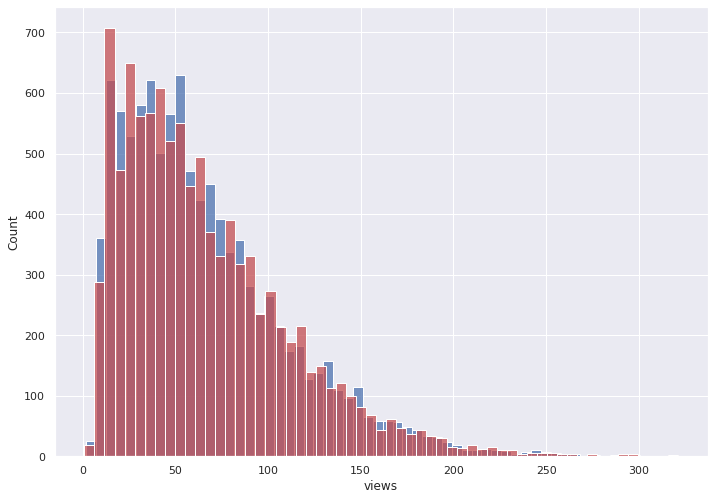

In [45]:
sns.histplot(df[df.exp_group == 1].views, color='b')
sns.histplot(df[df.exp_group == 2].views, color='r')

In [30]:
likes_diff = df[df['exp_group']==1].likes.sum() - df[df['exp_group']==2].likes.sum()
print ('Количество лайков контрольной группы выше, чем у тестовой на', likes_diff)

Количество лайков контрольной группы выше, чем у тестовой на 8626


<AxesSubplot:xlabel='likes', ylabel='Count'>

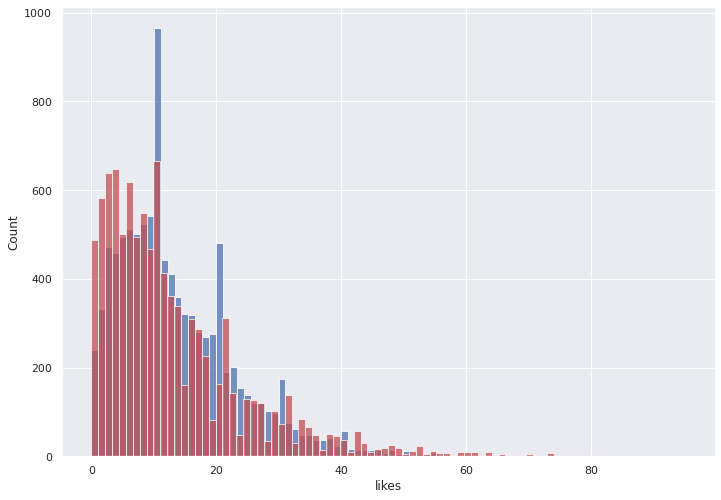

In [44]:
sns.histplot(df[df.exp_group == 1].likes, color='b')

sns.histplot(df[df.exp_group == 2].likes, color='r')

In [43]:
print ('Среднее значение CTR в контрольной группе', df[df['exp_group']==1].ctr.mean().round(2))
print('Среднее значение CTR в тестовой группе', df[df['exp_group']==2].ctr.mean().round(2))

Среднее значение CTR в контрольной группе 0.22
Среднее значение CTR в тестовой группе 0.21


#### Пользователи не охотно пользуются новой фичей приложения, т.к. упали как лайки, так и просмотры, хотя средние значение CTR осталисб неизменными.
#### Судя по графикам, в контрольной группе были выборосы лайков, и наша фича позволила пользователям лайкать именно то, что им нравится.
#### Я бы посоветовал не выкатывать новую фичу, если мы рассчитываем на увеличение CTR, т.к. его среднее значение, хоть и не существенно, но оказалось меньше, чем у контрольной группы.